In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
# long_table = pd.read_csv(
#     '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
# )

# long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
# long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# # Adjustment needed to match the introns in Yang's annotation...
# long_table.stop += 1

# long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
#                  right_on=['chrom', 'start', 'end', 'strand'])


In [2]:
fp_scores = pd.read_csv('../code/SplicingAnalysis/MaxEntScan/Annotation/FivePrime.score.tab.gz', sep='\t',
                       names = ['intron_id', 'sequence', 'MaxEntScan'])

fp_scores[['intron', 'ss_coords']] = fp_scores.intron_id.str.split('::', 1, expand=True)

In [3]:
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

In [4]:
def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

chRNA_clusters, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')

In [5]:
chRNA_clusters = chRNA_clusters.merge(fp_scores, left_on='intron', right_on='intron').merge(intron_annot, 
                                                                          left_on=['chrom', 'start', 'end', 'strand', 'intron'],
                                                                          right_on = ['chrom', 'start', 'end', 'strand', 'junction'])

chRNA_clusters = chRNA_clusters.loc[chRNA_clusters.gene.isin(expressed_genes.gene)]

chRNA_clusters['isPC'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']))
chRNA_clusters['isNMD'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']))

NMD_clusters = chRNA_clusters.groupby('cluster').isNMD.any().reset_index()
NMD_clusters.columns = ['cluster', 'isNMD_cluster']

chRNA_clusters = chRNA_clusters.merge(NMD_clusters, left_on='cluster', right_on='cluster')

In [6]:
def get_NMD_ratio(clu, chRNA_samples):
    
    if clu.isNMD.any():
    
        NMD_reads = int(clu.loc[clu.isNMD, chRNA_samples].sum().sum())
        SS_type = 'alt_NMD'
        
    else:
        NMD_reads = 0
        SS_type = 'alt_PC'
        
    PC_reads = int(clu.loc[clu.isPC, chRNA_samples].sum().sum())
    
    MES = clu.MaxEntScan.max()
    
    total_reads = (NMD_reads + PC_reads)
    NMD_ratio = NMD_reads / total_reads
    
    return SS_type, total_reads, NMD_ratio, MES

In [7]:
junc_name = []
total_reads = []
NMD_ratio = []
MES_5p = []
SS_type = []

for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '+'].groupby(['chrom', 'start', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
        
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '+'])
        
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)
        
for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '-'].groupby(['chrom', 'end', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '-'])
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38792/38792 [01:19<00:00, 485.83it/s]


In [8]:
df_5p = pd.DataFrame()
df_5p['total_reads'] = total_reads
df_5p['NMD_ratio'] = NMD_ratio
df_5p['MES_5p'] = MES_5p
df_5p['SS_type'] = SS_type
df_5p.index = junc_name

<Axes: xlabel='SS_type', ylabel='MES_5p'>

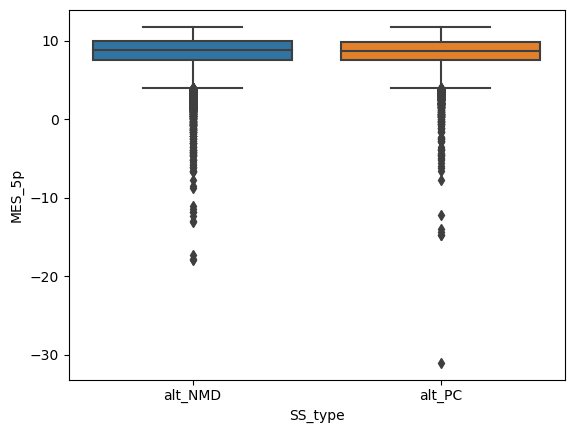

In [9]:
sns.boxplot(data = df_5p, x='SS_type', y='MES_5p')

In [10]:
df_5p.loc[(df_5p.total_reads >= 1000)]

,total_reads,NMD_ratio,MES_5p,SS_type
chr1:962047:+,2601,0.101499,8.878340,alt_NMD
chr1:962471:+,7487,0.020435,8.481119,alt_NMD
chr1:962917:+,5827,0.422687,6.233342,alt_NMD
chr1:963253:+,3106,0.016098,9.144005,alt_NMD
chr1:963504:+,5054,0.004947,6.296681,alt_NMD
...,...,...,...,...
chr9:137576080:-,3966,0.186334,7.699789,alt_NMD
chr9:137577470:-,7692,0.593604,2.049875,alt_NMD
chr9:137578625:-,9936,0.148953,9.045674,alt_NMD
chr9:137587717:-,7044,0.048836,4.288866,alt_NMD


In [11]:
df_5p.loc[(df_5p.NMD_ratio <= 0.2) & (df_5p.NMD_ratio >= 0.1) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

8.480101059572789

In [12]:
df_5p.loc[(df_5p.NMD_ratio >= 0.9) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

7.408980528989146

In [13]:
df_5p.loc[(df_5p.NMD_ratio <= 0.25) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

8.483858567256119

In [14]:
df_5p.loc[(df_5p.NMD_ratio <= 0.5) & (df_5p.NMD_ratio >= 0.25) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

8.313643174655196

In [15]:
df_5p.loc[(df_5p.NMD_ratio <= 0.75) & (df_5p.NMD_ratio >= 0.5) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

8.065194367807374

In [16]:
df_5p.loc[(df_5p.NMD_ratio >= 0.75) & (df_5p.SS_type != 'const_PC')].MES_5p.mean()

7.631394064271592

In [17]:
(df_5p.loc[(df_5p.NMD_ratio <= 0.01) & (df_5p.total_reads >= 1000)].MES_5p).mean()

8.465083309098542

In [18]:
(df_5p.loc[(df_5p.NMD_ratio >= 0.01) & (df_5p.NMD_ratio <= 0.1) & (df_5p.total_reads >= 1000)].MES_5p).mean()

8.541466470702604

In [19]:
df_5p.loc[(df_5p.NMD_ratio > 0.75) & (df_5p.NMD_ratio <= 1)].MES_5p

chr1:6807088:+       9.485706
chr1:19882720:+      4.049429
chr1:33098179:+      9.597037
chr1:43992639:+     11.083002
chr1:95244715:+    -17.940653
                      ...    
chr9:131270292:-    10.068356
chr9:131270460:-     5.850377
chr9:133344125:-     7.457458
chr9:133476233:-     4.986789
chr9:136741881:-    11.453292
Name: MES_5p, Length: 353, dtype: float64

In [20]:
from decimal import Decimal 

def plot_clumulative(y, steps = 100):
    X = np.linspace(np.min(y), np.max(y), 100)
    y = np.array(y)
    Y = [np.mean(y<=x) for x in X]
    
    return X, Y

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)
    
def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval


In [21]:
df_5p = df_5p.loc[df_5p.SS_type == 'alt_NMD']

In [22]:
len(np.array(df_5p.loc[(df_5p.NMD_ratio > -1) & (df_5p.NMD_ratio <= 0.25)].MES_5p))

20084

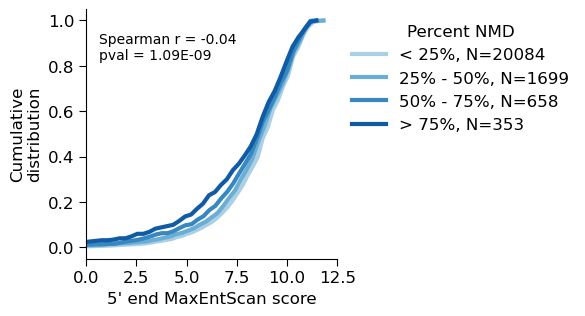

In [23]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Blues", 5)
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))
N = len(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))
N_ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))

X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))
N__ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))
N___ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='< 25%, N='+str(N))
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='25% - 50%, N='+str(N_))
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='50% - 75%, N='+str(N__))
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='> 75%, N='+str(N___))
ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title='Percent NMD', bbox_to_anchor=(1, 1), fontsize=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12)

ax.set_xlabel("5' end MaxEntScan score", size=12)
ax.set_ylabel('Cumulative\ndistribution', size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)


annotate_pval(df_5p.NMD_ratio, df_5p.MES_5p, ax, xy = (0.05, 0.8), col='black')

fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Supplement_MaxEntScan_FivePrime.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Supplement_MaxEntScan_FivePrime.png', dpi=300, bbox_inches='tight',)

Text(0, 0.5, 'CDF')

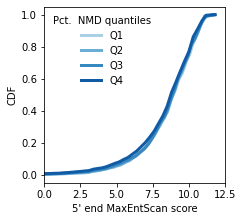

In [291]:
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.25))].MES_5p))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.25)) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.5))].MES_5p))
X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.5)) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.75))].MES_5p))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.75)) & (df_5p.NMD_ratio <= 1)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='Q1')
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='Q2')
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='Q3')
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='Q4')
ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title='Pct.  NMD quantiles')
ax.set_xlabel("5' end MaxEntScan score")
ax.set_ylabel('CDF')

Text(0, 0.5, 'CDF')

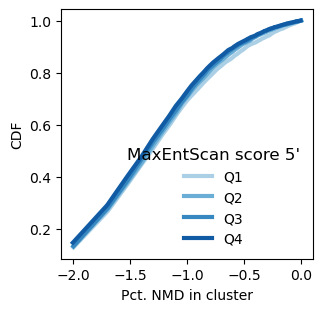

In [24]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Blues", 5)
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p <= df_5p.MES_5p.quantile(0.25))].NMD_ratio))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.25)) & (df_5p.MES_5p <= df_5p.MES_5p.quantile(0.5))].NMD_ratio))
X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.5)) & (df_5p.MES_5p <= df_5p.MES_5p.quantile(0.75))].NMD_ratio))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.75)) ].NMD_ratio))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(np.log10(X[1:]), Y[1:], c=colores[1], linewidth = 3, label='Q1')
ax.plot(np.log10(X_[1:]), Y_[1:], c=colores[2], linewidth = 3, label='Q2')
ax.plot(np.log10(X__[1:]), Y__[1:], c=colores[3], linewidth = 3, label='Q3')
ax.plot(np.log10(X___[1:]), Y___[1:], c=colores[4], linewidth = 3, label='Q4')
# ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title="MaxEntScan score 5'")
ax.set_xlabel("Pct. NMD in cluster")
ax.set_ylabel('CDF')

In [294]:
df_5p.loc[(df_5p.NMD_ratio <= 0.25)]

,total_reads,NMD_ratio,MES_5p,SS_type
chr1:962047:+,2601,0.101499,8.878340,alt_NMD
chr1:962471:+,7487,0.020435,8.481119,alt_NMD
chr1:963253:+,3106,0.016098,9.144005,alt_NMD
chr1:963504:+,5054,0.004947,6.296681,alt_NMD
chr1:964530:+,8803,0.051005,5.128678,alt_NMD
...,...,...,...,...
chr9:137574752:-,9090,0.028603,10.512265,alt_NMD
chr9:137576080:-,3966,0.186334,7.699789,alt_NMD
chr9:137578625:-,9936,0.148953,9.045674,alt_NMD
chr9:137587717:-,7044,0.048836,4.288866,alt_NMD


In [302]:
spearmanr(df_5p.loc[df_5p.total_reads > 0].NMD_ratio, df_5p.loc[df_5p.total_reads > 0].MES_5p)

SpearmanrResult(correlation=-0.040359237246604424, pvalue=1.0912423585091542e-09)

In [24]:
fp_scores = pd.read_csv('../code/SplicingAnalysis/MaxEntScan/Annotation/ThreePrime.score.tab.gz', sep='\t',
                       names = ['intron_id', 'sequence', 'MaxEntScan'])

fp_scores[['intron', 'ss_coords']] = fp_scores.intron_id.str.split('::', 1, expand=True)

In [25]:
chRNA_clusters, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')

chRNA_clusters = chRNA_clusters.merge(fp_scores, left_on='intron', right_on='intron').merge(intron_annot, 
                                                                          left_on=['chrom', 'start', 'end', 'strand', 'intron'],
                                                                          right_on = ['chrom', 'start', 'end', 'strand', 'junction'])

chRNA_clusters = chRNA_clusters.loc[chRNA_clusters.gene.isin(expressed_genes.gene)]

chRNA_clusters['isPC'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']))
chRNA_clusters['isNMD'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']))

NMD_clusters = chRNA_clusters.groupby('cluster').isNMD.any().reset_index()
NMD_clusters.columns = ['cluster', 'isNMD_cluster']

chRNA_clusters = chRNA_clusters.merge(NMD_clusters, left_on='cluster', right_on='cluster')

In [26]:
junc_name = []
total_reads = []
NMD_ratio = []
MES_5p = []
SS_type = []

for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '+'].groupby(['chrom', 'end', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
        
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '+'])
        
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)
        
for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '-'].groupby(['chrom', 'start', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '-'])
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39257/39257 [01:18<00:00, 498.44it/s]


In [27]:
df_5p = pd.DataFrame()
df_5p['total_reads'] = total_reads
df_5p['NMD_ratio'] = NMD_ratio
df_5p['MES_5p'] = MES_5p
df_5p['SS_type'] = SS_type
df_5p.index = junc_name

In [28]:
df_5p = df_5p.loc[df_5p.SS_type == 'alt_NMD']

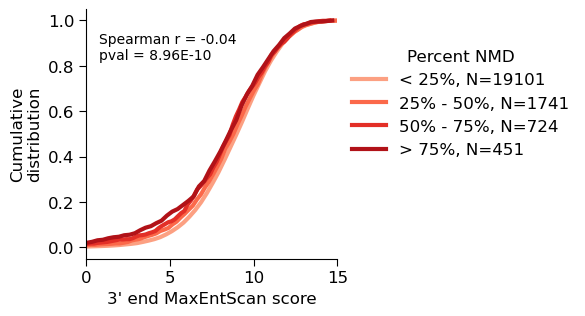

In [29]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Reds", 5)
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))
N = len(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))
N_ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))

X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))
N__ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))
N___ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='< 25%, N='+str(N))
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='25% - 50%, N='+str(N_))
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='50% - 75%, N='+str(N__))
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='> 75%, N='+str(N___))
ax.set_xlim([0, 15])
ax.legend(frameon=False, title='Percent NMD', bbox_to_anchor=(1, 0.9), fontsize=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12)

ax.set_xlabel("3' end MaxEntScan score", size=12)
ax.set_ylabel('Cumulative\ndistribution', size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)


annotate_pval(df_5p.NMD_ratio, df_5p.MES_5p, ax, xy = (0.05, 0.8), col='black')

fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Supplement_MaxEntScan_ThreePrime.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Supplement_MaxEntScan_ThreePrime.png', dpi=300, bbox_inches='tight',)

Text(0, 0.5, 'CDF')

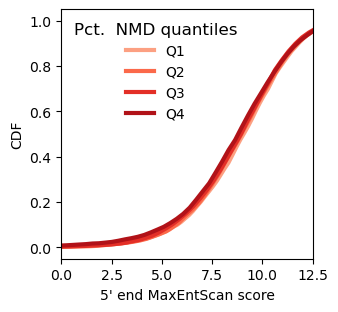

In [33]:
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.25))].MES_5p))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.25)) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.5))].MES_5p))
X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.5)) & (df_5p.NMD_ratio <= df_5p.NMD_ratio.quantile(0.75))].MES_5p))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > df_5p.NMD_ratio.quantile(0.75)) & (df_5p.NMD_ratio <= 1)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='Q1')
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='Q2')
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='Q3')
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='Q4')
ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title='Pct.  NMD quantiles')
ax.set_xlabel("5' end MaxEntScan score")
ax.set_ylabel('CDF')

Text(0, 0.5, 'CDF')

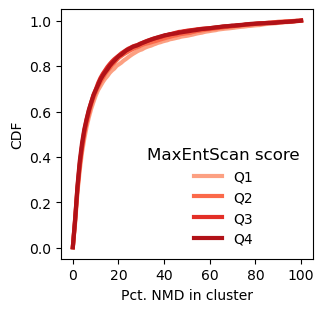

In [34]:
X, Y = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p <= df_5p.MES_5p.quantile(0.25))].NMD_ratio))

X_, Y_ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.25)) & (df_5p.MES_5p <= df_5p.MES_5p.quantile(0.5))].NMD_ratio))
X__, Y__ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.5)) & (df_5p.MES_5p <= df_5p.MES_5p.quantile(0.75))].NMD_ratio))

X___, Y___ = plot_clumulative(np.array(df_5p.loc[(df_5p.MES_5p > df_5p.MES_5p.quantile(0.75)) ].NMD_ratio))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X*100, Y, c=colores[1], linewidth = 3, label='Q1')
ax.plot(X_*100, Y_, c=colores[2], linewidth = 3, label='Q2')
ax.plot(X__*100, Y__, c=colores[3], linewidth = 3, label='Q3')
ax.plot(X___*100, Y___, c=colores[4], linewidth = 3, label='Q4')
# ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title='MaxEntScan score')
ax.set_xlabel("Pct. NMD in cluster")
ax.set_ylabel('CDF')